## Final Project Submission

Please fill out:
* Student name: Xinjia (Carrie) Liu
* Student pace: self paced
* Scheduled project review date/time: September 27, 2021 / 11AM EST
* Instructor name: Jeff Herman
* Blog post URL:

# Data Analysis on King County Housing Market

## Overview

This project analyzes 2014-2015 the King County house sales data for a local real estate agency that helps homeowners buy and/or sell homes. The analysis will follow Cross-Industry Standard Process for Data Mining (CRISP-DM). Based on the validated model and exploratory analysis, the real estate agency will provide useful advice to homeowners about what factors determine the value of their homes

## Business Problem

Local real estate agents usually face such questions from homeowners as: how home renovations might increase the estimated value of their homes, and by what amount; whether a view of waterfront increases the house sale price; and etc.

Upon analyzing the King County house sales data, we will help local real estate angency to answer the questions from their clients, i.e. homeowners. We will help figure out what are the key features that determine the house values, and by what amount. 

## Data Understanding

This dataset contains house sale prices for King County. It includes homes sold between May 2014 and May 2015. 

* The target: Sale Price
* The predictors available to us: the sale date, renovation year, number of bedrooms and bathrooms, number of floors, the square footage of the houses (both living and lot), and available view of waterfront. Also, the dataset contains the grade and condition of each house. 
* Datatypes: Except for date and sqft_basement (object), others are integer or float.
* Distribution of our data: 
    - continuous: sqft_living, sqft_lot, sqft_above, sqft_basement (after adjustment), gap year between sold and built/renovated
    - discrete: bedrooms, bathrooms, floors, condition, grade
    - dummy: waterfront, renovation (after adjustment)
* Our datasets contain 21,597 items of house sale information
* We will eliminate the information such as house ID, zipcode, latitude and longitude, the square footage of interior housing living space/lot for the nearest 15 neighbors, and whether the house has been viewed or not.

### Import Necessary Packages and Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

/Users/carrie/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('data/kc_house_data.csv')

In [4]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [5]:
df = data.drop(['id','view','zipcode','lat','long'], axis=1)

In [6]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by = 'date')

In [7]:
df.head(5)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
7316,2014-05-02,435000.0,4,1.0,1450,8800,1.0,0.0,4,7,1450,0.0,1954,0.0,1260,8942
20586,2014-05-02,555000.0,4,2.5,3310,6500,2.0,0.0,3,8,3310,0.0,2012,0.0,2380,5000
1040,2014-05-02,550000.0,4,2.5,1940,10500,1.0,NaN,4,7,1140,800.0,1976,0.0,2200,10500
20543,2014-05-02,295000.0,2,2.5,1630,1368,2.0,0.0,3,7,1280,350.0,2009,0.0,1590,2306
9587,2014-05-02,790000.0,3,2.5,2600,4750,1.0,0.0,4,9,1700,900.0,1951,0.0,2380,4750


In [8]:
df.shape

(21597, 16)

## EDA - Exploratory Data Analysis

### Check Missing Data

In [9]:
df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
sqft_living15       0
sqft_lot15          0
dtype: int64

In [10]:
#waterfront
df['waterfront'].value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [11]:
df['waterfront']= df['waterfront'].fillna(0)

In [12]:
df['waterfront'].value_counts()

0.0    21451
1.0      146
Name: waterfront, dtype: int64

In [13]:
#yr_renovated
df['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1976.0        1
1944.0        1
1948.0        1
1950.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [14]:
df['yr_renovated']= df['yr_renovated'].fillna(0)

In [15]:
df['yr_renovated'].value_counts()

0.0       20853
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1976.0        1
1944.0        1
1948.0        1
1950.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [16]:
#sanity check of missing data
df.isna().sum().sum()

0

In [17]:
#sqft_basement
df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
666.0         1
1275.0        1
1913.0        1
248.0         1
2180.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [18]:
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: np.nan if x == '?' else x)
df['sqft_basement']= df['sqft_basement'].fillna(0)

### Check Data Types

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7316 to 16580
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21597 non-null  datetime64[ns]
 1   price          21597 non-null  float64       
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     21597 non-null  float64       
 8   condition      21597 non-null  int64         
 9   grade          21597 non-null  int64         
 10  sqft_above     21597 non-null  int64         
 11  sqft_basement  21597 non-null  object        
 12  yr_built       21597 non-null  int64         
 13  yr_renovated   21597 non-null  float64       
 14  sqft_living15  21597 non-null  int64         
 15  sqft_lot15     2

In [20]:
#date
df['yr_sold'] = df['date'].dt.year

In [21]:
df['yr_sold'].value_counts()

2014    14622
2015     6975
Name: yr_sold, dtype: int64

In [22]:
#convert from float to int
df['yr_renovated'] = df['yr_renovated'].astype(int)
df['waterfront'] = df['waterfront'].astype(int)
df['sqft_basement'] = df['sqft_basement'].astype(float)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7316 to 16580
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21597 non-null  datetime64[ns]
 1   price          21597 non-null  float64       
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     21597 non-null  int64         
 8   condition      21597 non-null  int64         
 9   grade          21597 non-null  int64         
 10  sqft_above     21597 non-null  int64         
 11  sqft_basement  21597 non-null  float64       
 12  yr_built       21597 non-null  int64         
 13  yr_renovated   21597 non-null  int64         
 14  sqft_living15  21597 non-null  int64         
 15  sqft_lot15     2

### Add/Remove Data

#### Create New Columns 

In [24]:
#Gap year between yr_sold and yr_built
df['age_built'] = df['yr_sold'] - df['yr_built']

In [25]:
#Create renovated status column
df['renovation'] = 0
for idx, x in enumerate(df['yr_renovated']):
    if x:
        df['renovation'][idx] = 1
    else:
        df['renovation'][idx] = 0

#### Delete Questionable Data

In [26]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,yr_sold,age_built,renovation
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.006760,3.409825,7.657915,1788.596842,285.716581,1970.999676,68.758207,1986.620318,12758.283512,2014.322962,43.323286,0.034449
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.081944,0.650546,1.173200,827.759761,439.819830,29.375234,364.037499,685.230472,27274.441950,0.467619,29.377285,0.182384
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,399.000000,651.000000,2014.000000,-1.000000,0.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,1490.000000,5100.000000,2014.000000,18.000000,0.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,1840.000000,7620.000000,2014.000000,40.000000,0.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,4.000000,8.000000,2210.000000,550.000000,1997.000000,0.000000,2360.000000,10083.000000,2015.000000,63.000000,0.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,6210.000000,871200.000000,2015.000000,115.000000,1.000000


In [27]:
df[df['age_built'] == -1]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,yr_sold,age_built,renovation
21356,2014-05-20,490000.0,5,3.50,4460,2975,3.0,0,3,10,3280,0.0,2015,0,2490,4231,2014,-1,0
17084,2014-06-17,350000.0,3,2.00,1380,3600,3.0,0,3,8,1380,0.0,2015,0,1480,3600,2014,-1,0
8032,2014-06-24,455000.0,2,1.50,1200,1259,2.0,0,3,8,1000,200.0,2015,0,1320,1852,2014,-1,0
1761,2014-06-25,597326.0,4,4.00,3570,8250,2.0,0,3,10,2860,710.0,2015,0,2230,10000,2014,-1,0
20836,2014-07-09,595000.0,4,3.25,3730,4560,2.0,0,3,9,2760,970.0,2015,0,1800,4560,2014,-1,0
20947,2014-07-31,230000.0,3,1.50,1040,1264,2.0,0,3,9,900,140.0,2015,0,1350,3000,2014,-1,0
19789,2014-08-01,455000.0,3,1.75,1320,1014,3.0,0,3,9,1320,0.0,2015,0,1380,1495,2014,-1,0
14475,2014-08-26,500000.0,2,2.25,1570,1269,2.0,0,3,9,1280,290.0,2015,0,1570,6000,2014,-1,0
20754,2014-08-28,357000.0,5,2.50,2990,9240,2.0,0,3,8,2990,0.0,2015,0,1970,18110,2014,-1,0
2685,2014-10-29,385195.0,1,1.00,710,6000,1.5,0,3,6,710,0.0,2015,0,1440,4800,2014,-1,0


In [28]:
df = df.loc[~(df['age_built'] == -1)]

In [29]:
df = df.drop('date', axis=1)

### Check Assumptions associated with a Linear Regression Model

There are four assumptions associated with a linear regression model:

- Linearity: The relationship between X and the mean of Y is linear. (check by visualization)
- Homoscedasticity: The variance of residual is the same for any value of X.
- Independence: Observations are independent of each other.
- Normality: For any fixed value of X, Y is normally distributed. （Q-Q plots）

Before modeling, we will check the linearity and multicollinearity here. 

At the same time, we will invetigate the the relationship between our target: price and the predictors by data visualization. We will also remove outliers from the skewed data.

#### Target: Price

In [30]:
df['price'].describe()

count    2.158500e+04
mean     5.403381e+05
std      3.674563e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

<AxesSubplot:>

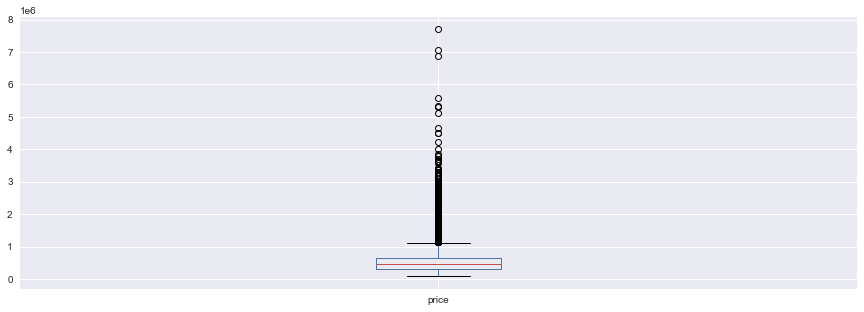

In [31]:
df['price'].plot.box(figsize = (15,5))

<AxesSubplot:xlabel='price', ylabel='Count'>

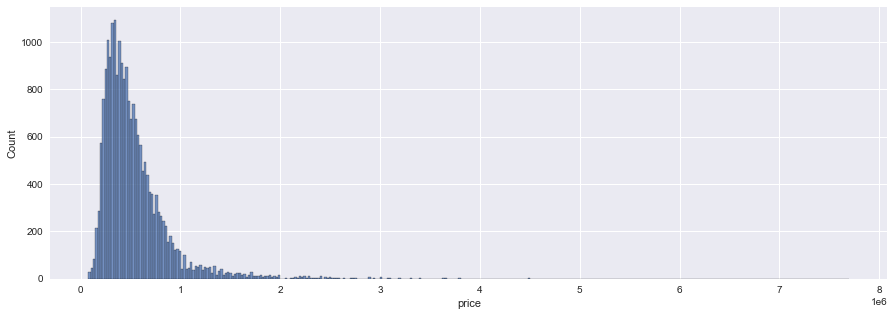

In [32]:
plt.figure(figsize=(15,5))
sns.histplot(data=df, x='price')

In [33]:
#drop the outliers of prices
df = df[df['price'] <= 1000000]

In [34]:
df['price'].value_counts().sum()

20127

Comments:

- We notice that the price data is heavily skewed. There's many outliers from the price data. The average price of houses in King County is USD 540K, and the median price is USD 450K, which is associated with the affordability of middle class family. However, the max value of house is USD 7.7 million, much larger than the median price. 

- Given most clients of real estate agency are middle class. In order to reduce the skewness, we will remove the houses with prices over USD 1M (keeping 93% of data). 

#### Price vs Bedrooms

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

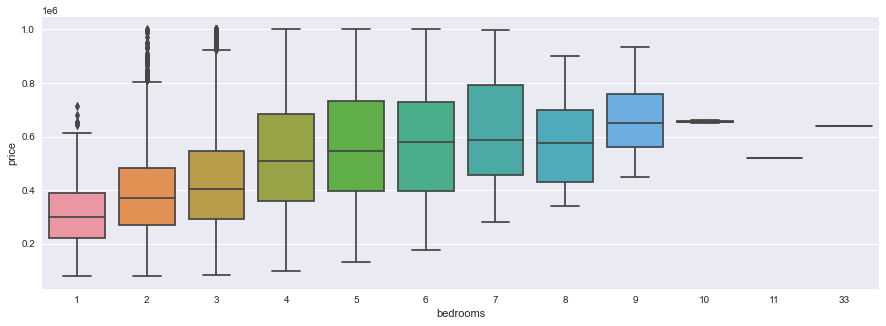

In [35]:
plt.figure(figsize=(15,5))
sns.boxplot(x='bedrooms', y='price', data=df)

In [36]:
df['bedrooms'].value_counts()

3     9516
4     6145
2     2724
5     1283
6      218
1      194
7       30
8        9
9        4
10       2
11       1
33       1
Name: bedrooms, dtype: int64

In [37]:
#drop the outlier of bedrooms
df = df[df['bedrooms'] <= 6]

In [38]:
df['bedrooms'].value_counts().sum()

20080

Comments:

- There's linearity between price and bedrooms. The more the bedrooms, the higher the value of houses.
- Most houses have no more than 6 bedrooms.(keeping 99.8% data)

#### Price vs Bathrooms

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

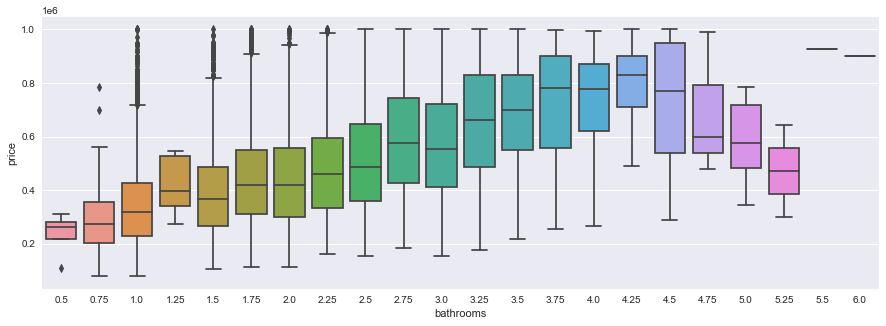

In [39]:
plt.figure(figsize=(15,5))
sns.boxplot(x='bathrooms', y='price', data=df)

In [40]:
df['bathrooms'].value_counts()

2.50    5120
1.00    3841
1.75    3003
2.25    1932
2.00    1899
1.50    1424
2.75    1065
3.00     633
3.50     497
3.25     385
0.75      71
3.75      66
4.00      53
4.50      43
4.25      24
1.25       7
5.00       6
0.50       4
4.75       3
5.25       2
6.00       1
5.50       1
Name: bathrooms, dtype: int64

In [41]:
#drop the outlier of bedrooms
df = df[(df['bathrooms'] > 0.5) & (df['bathrooms'] <= 4)]

In [42]:
df['bathrooms'].value_counts().sum()

19996

Comments:

- There's linearity between price and bathrooms. The more the bathrooms, the higher the value of houses.
- Most houses have at least 1 bathrooms, but no more than 4 bathrooms. (keeping 99.6% data)

#### Price vs Floors

<AxesSubplot:xlabel='floors', ylabel='price'>

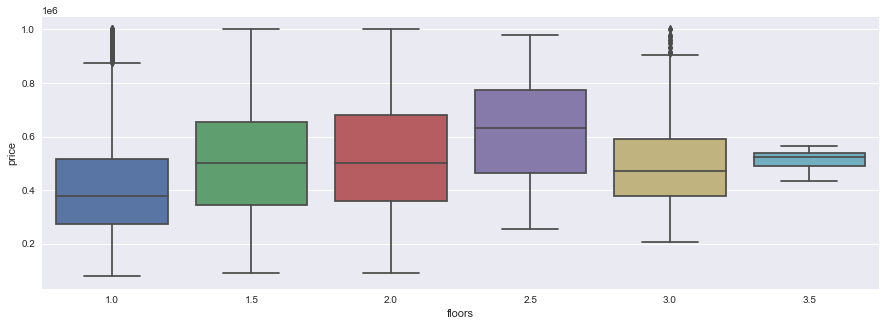

In [43]:
plt.figure(figsize=(15,5))
sns.boxplot(x='floors', y='price', data=df)

In [44]:
df['floors'].value_counts()

1.0    10347
2.0     7192
1.5     1792
3.0      555
2.5      104
3.5        6
Name: floors, dtype: int64

In [45]:
#drop the outlier of floors
df = df[df['floors'] <= 3]

In [46]:
df['floors'].value_counts().sum()

19990

Comments:

- There's linearity between price and floors when the floors are fewer than 3. We might use one-hot encoding on this categorical feature.
- The number of floors is also associated with whether there's basement or not. So this feature has correlationship with sqft variables.

#### Price vs Conditions

<AxesSubplot:xlabel='condition', ylabel='price'>

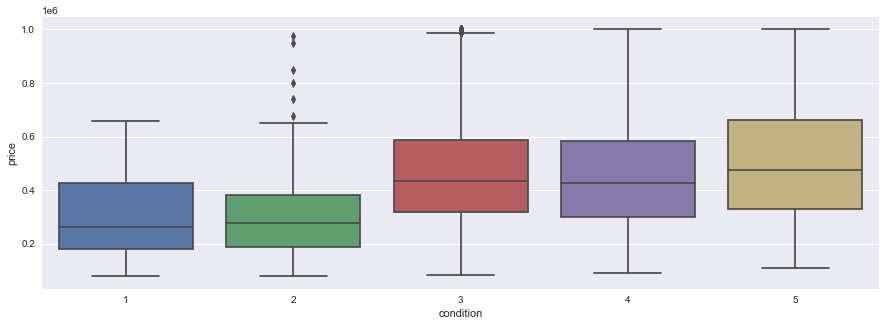

In [47]:
plt.figure(figsize=(15,5))
sns.boxplot(x='condition', y='price', data=df)

Comments:

- There's linearity between price and condition, but not obvious. The better the condition, the higher the price.
- The value descriptions for this column state that it is coded on a 1–5 linear scale, with 1 being ‘poor’ and 5 being ‘very good.’
- We will use the One-Hot Encoding to further analyze the data.

In [48]:
# One-Hot Encoding on condition, which feature has no clear linearity
one_hot_condition = pd.get_dummies(df['condition'], prefix='condition') 
# we drop the middle condition level
one_hot_condition.drop('condition_3', axis=1)

,condition_1,condition_2,condition_4,condition_5
7316,0,0,1,0
20586,0,0,0,0
1040,0,0,1,0
20543,0,0,0,0
9587,0,0,1,0
...,...,...,...,...
11548,0,0,0,0
19381,0,0,1,0
12623,0,0,1,0
5632,0,0,0,0


In [49]:
df = pd.concat([df, one_hot_condition], axis=1)

#### Price vs Grade

<AxesSubplot:xlabel='grade', ylabel='price'>

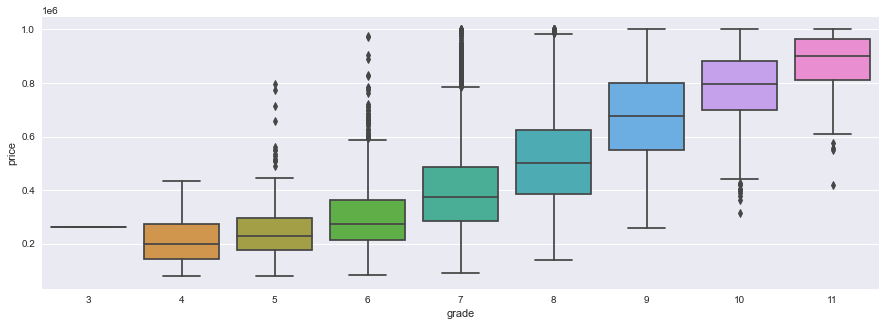

In [50]:
plt.figure(figsize=(15,5))
sns.boxplot(x='grade', y='price', data=df)

In [51]:
df['grade'].value_counts()

7     8911
8     5828
9     2203
6     2029
10     667
5      241
11      83
4       27
3        1
Name: grade, dtype: int64

In [52]:
#drop the outlier of floors
df = df[df['grade'] > 3]

Comments:

- There's linearity between price and grade. The higher the grade, the higher the price.
- Most the grade is between 4 and 11.

#### Price vs Sqft

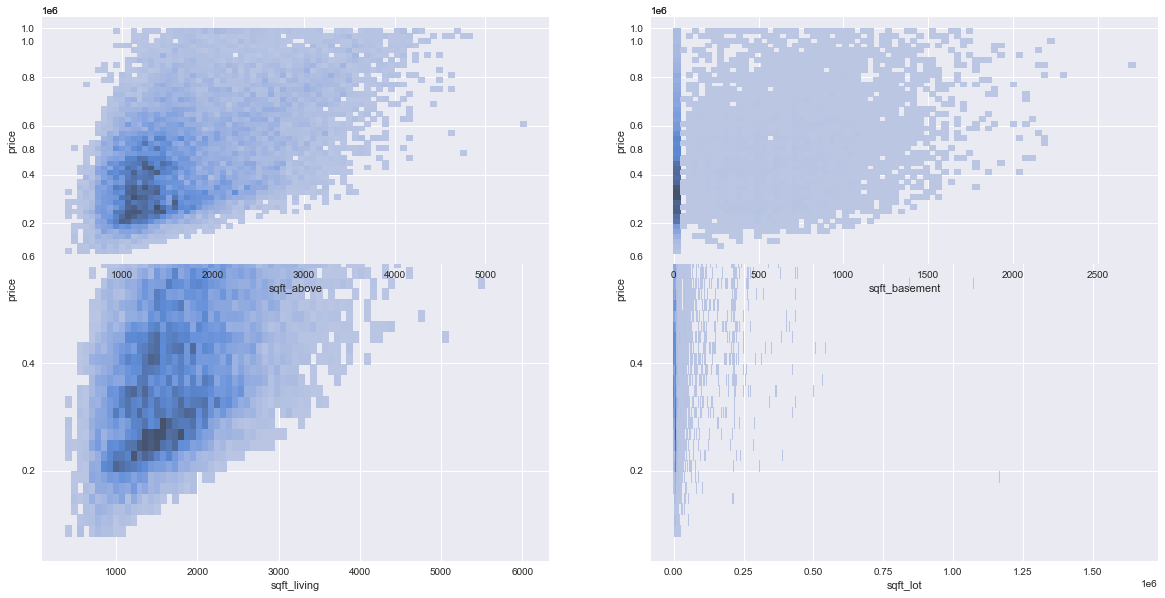

In [53]:
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(121)
ax1 = sns.histplot(data=df, x='sqft_living', y='price')

ax2 = fig.add_subplot(122)
ax2 = sns.histplot(data=df, x='sqft_lot', y='price')

ax3 = fig.add_subplot(221)
ax3 = sns.histplot(data=df, x='sqft_above', y='price')

ax4 = fig.add_subplot(222)
ax4 = sns.histplot(data=df, x='sqft_basement', y='price')

Comments:

- The patterns of price vs sqft_above and price vs sqft_living are similar, because sqft_living is largely determined by sqft_above.

#### Price vs Waterfront and Renovation

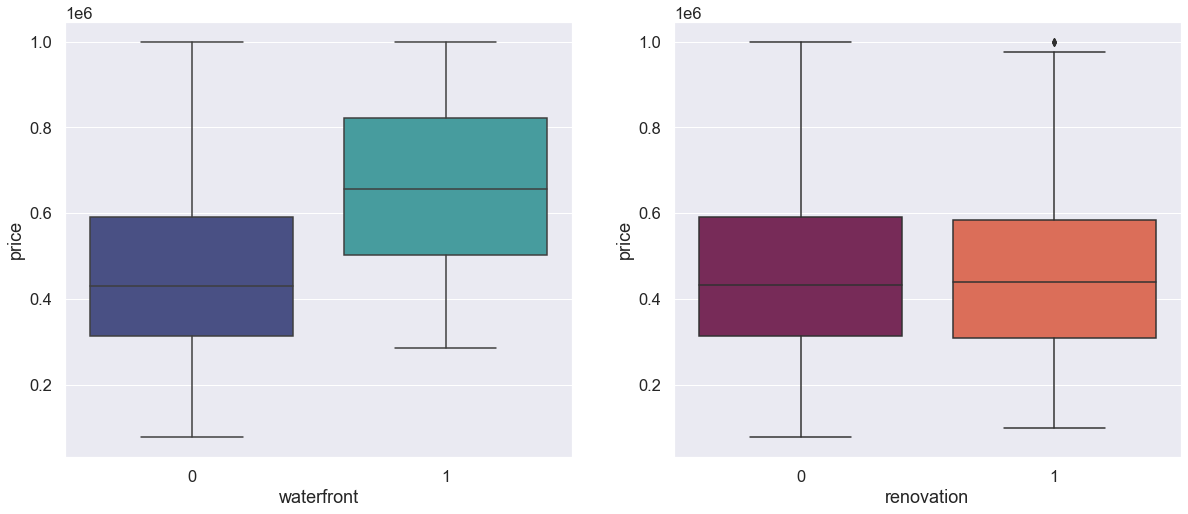

In [54]:
fig = plt.figure(figsize=(20,8))
sns.set(font_scale=1.5)

ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x='waterfront', y='price', data=df, palette = 'mako')

ax2 = fig.add_subplot(122)
ax2 = sns.boxplot(x='renovation', y='price', data=df, palette = 'rocket')

Comments:

- There's linearity between price and waterfront, but there's no linearity between price and renovation.

#### Price vs Yr_built

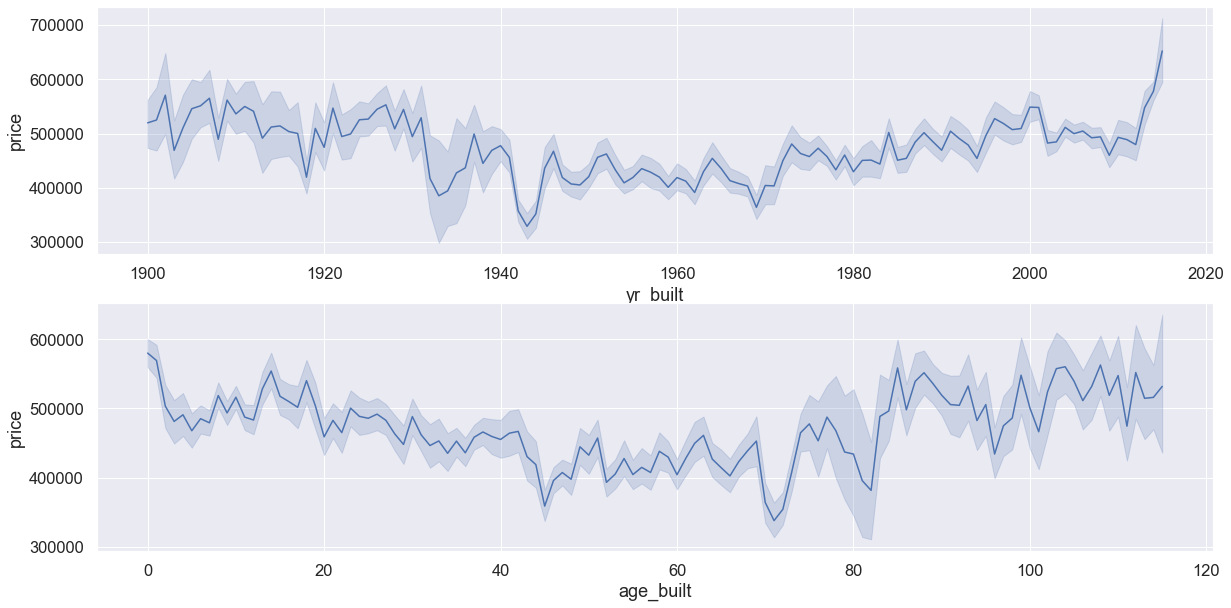

In [55]:
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(211)
ax1 = sns.lineplot(x='yr_built', y='price', data=df)

ax2 = fig.add_subplot(212)
ax2 = sns.lineplot(x='age_built', y='price', data=df)

Comments:

- There's no linearity between price and the year of built.
- For the age of houses is below 70 years old, the value of the older properties is lower. However, once the houses is over 70 years old, the value of the older properties is increasing / higher. Therefore, we can split the age_built into two categories 0-70 and 70+. Given there's no obvious relationship between price and renovation, we only consider the age of houses determined by the year built.
- A new column of age_above_70 has been added in the above steps

In [56]:
#split the age_built into two categories
bins = [0,70,120]
labels = ['0-70', 'above_70']
df['age_above_70'] = pd.cut(df['age_built'], bins = bins, labels = labels)

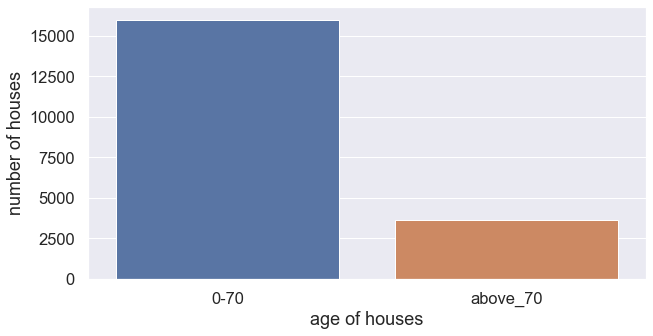

In [57]:
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(x=labels, y=df.groupby('age_above_70')['price'].count(), data=df)
ax.set(xlabel='age of houses', ylabel='number of houses');

In [58]:
df['age_above_70'].value_counts()

0-70        16009
above_70     3609
Name: age_above_70, dtype: int64

<AxesSubplot:xlabel='age_above_70', ylabel='price'>

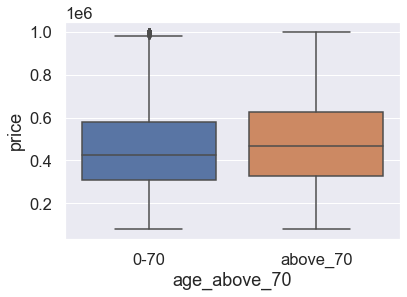

In [59]:
sns.boxplot(x='age_above_70', y='price', data=df)

In [60]:
# One-Hot Encoding on age_above_70
one_hot_age = pd.get_dummies(df['age_above_70'], drop_first=True) 
one_hot_age

,above_70
7316,0
20586,0
1040,0
20543,0
9587,0
...,...
11548,0
19381,0
12623,0
5632,0


In [61]:
df = pd.concat([df, one_hot_age], axis=1)

#### Investigate Linearity Assumption

Based on the data visulization above, most predictors have linearity relationship with our target variable: price, except:
* renovation (whether the house is renovated or not)
* age of the house (yr_built: when the house was built)

#### Investigate Multicollinearity

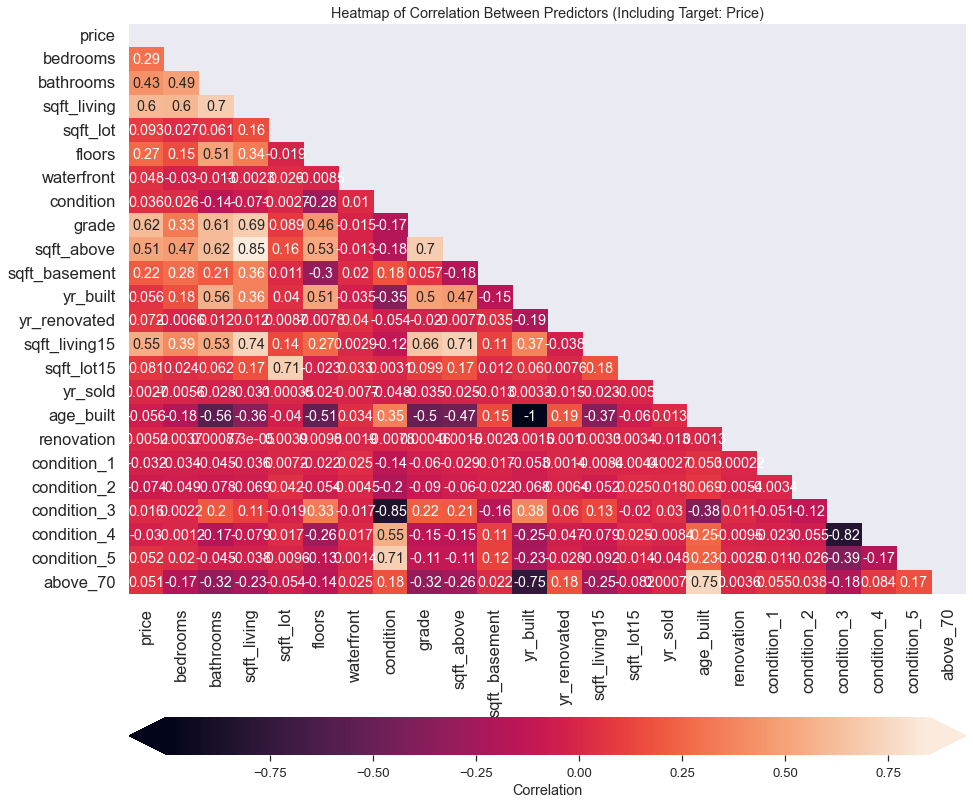

In [62]:
fig, ax = plt.subplots(figsize=(15,15))
sns.set(font_scale=1.2)

# Plot a heatmap of the correlation matrix, 
# with both numbers and colors indicating the correlations
sns.heatmap(
    data=df.corr(),
    mask=np.triu(np.ones_like(df.corr(), dtype=bool)),
    ax=ax,
    annot=True,
    cbar_kws={"label": "Correlation", "orientation": "horizontal", 
              "pad": 0.15, "extend": "both"}
)
ax.set_title("Heatmap of Correlation Between Predictors (Including Target: Price)");

In [63]:
df.corr().sort_values('price', ascending=False)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,...,sqft_lot15,yr_sold,age_built,renovation,condition_1,condition_2,condition_3,condition_4,condition_5,above_70
price,1.000000,0.291070,0.433584,0.601785,0.093223,0.266458,0.048032,0.036022,0.615218,0.510903,...,0.081026,0.002675,-0.055641,0.005172,-0.031954,-0.073827,0.015667,-0.029972,0.051808,0.051003
grade,0.615218,0.329889,0.608781,0.693929,0.088951,0.456732,-0.015193,-0.172634,1.000000,0.700178,...,0.099134,-0.034692,-0.498254,0.000456,-0.059798,-0.089793,0.220403,-0.147896,-0.111307,-0.317785
sqft_living,0.601785,0.600907,0.701412,1.000000,0.157326,0.335136,-0.002262,-0.071350,0.693929,0.846236,...,0.171902,-0.030855,-0.359256,0.000073,-0.036451,-0.068809,0.110428,-0.079291,-0.037952,-0.234930
sqft_living15,0.546927,0.392394,0.525020,0.736537,0.140650,0.266873,0.002947,-0.121177,0.661191,0.714954,...,0.177017,-0.023459,-0.366706,0.003349,-0.008398,-0.052201,0.134973,-0.079244,-0.092046,-0.250396
sqft_above,0.510903,0.473157,0.621452,0.846236,0.159740,0.530302,-0.013215,-0.179298,0.700178,1.000000,...,0.173673,-0.025325,-0.467627,0.001511,-0.028699,-0.060306,0.211480,-0.147662,-0.110160,-0.262711
bathrooms,0.433584,0.488938,1.000000,0.701412,0.061430,0.506756,-0.013155,-0.137429,0.608781,0.621452,...,0.061821,-0.028258,-0.562833,0.000873,-0.045195,-0.077860,0.201373,-0.170592,-0.045195,-0.322686
bedrooms,0.291070,1.000000,0.488938,0.600907,0.026971,0.154962,-0.029598,0.026156,0.329889,0.473157,...,0.024298,-0.005622,-0.175636,0.003698,-0.033847,-0.049108,0.002216,-0.001158,0.019670,-0.174799
floors,0.266458,0.154962,0.506756,0.335136,-0.018758,1.000000,-0.008528,-0.277784,0.456732,0.530302,...,-0.022968,-0.021039,-0.514760,0.009811,-0.021518,-0.053917,0.328211,-0.262241,-0.132633,-0.142726
sqft_basement,0.215654,0.277461,0.206011,0.362539,0.011216,-0.302931,0.019676,0.175758,0.057305,-0.181043,...,0.012374,-0.012976,0.150720,-0.002293,-0.016779,-0.022239,-0.160114,0.108386,0.117982,0.022402
sqft_lot,0.093223,0.026971,0.061430,0.157326,1.000000,-0.018758,0.025682,-0.002744,0.088951,0.159740,...,0.705859,-0.000349,-0.040309,0.003917,0.007232,0.042311,-0.019471,0.017421,-0.009587,-0.054150


In [64]:
# Generally, a correlation with an absolute value around 0.7-0.8 or higher 
# is considered a high correlation. Here, we take 0.7 as a cut-off.
abs(df.corr()) > 0.75

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,...,sqft_lot15,yr_sold,age_built,renovation,condition_1,condition_2,condition_3,condition_4,condition_5,above_70
price,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
grade,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
sqft_above,False,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [65]:
df_cc=df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

In [66]:
df_cc['pairs'] = list(zip(df_cc.level_0, df_cc.level_1))

In [67]:
df_cc.set_index(['pairs'], inplace = True)

In [68]:
df_cc.drop(columns=['level_0', 'level_1'], inplace = True)

In [69]:
df_cc.columns = ['cc']

In [70]:
df_cc.drop_duplicates(inplace = True)

In [71]:
df_cc[(df_cc.cc > 0.75) & (df_cc.cc < 1.0)]

,cc
pairs,
"(yr_built, age_built)",0.999871
"(condition_3, condition)",0.853567
"(sqft_living, sqft_above)",0.846236
"(condition_3, condition_4)",0.817823


Comments:

- 'grade' has the highest coefficient with 'price', followed by sqft_living, sqft_above, sqft_living15, bedrooms, bathrooms, floors and sqft_basement (with the absolute value of coefficient > 0.2)
- There's multicollinearity between the following features:
    - yr_built and age_built: because the age_built feature is created based on yr_built
    - sqft_above and sqft_living: most houses don't have basement, the living space is mostly equal to the space above.

## Modeling

### Baseline Model

According to the linearity and multicollinearity analysis in EDA, we will build the baseline model based on selected predictors.

In [72]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15', 'yr_sold',
       'age_built', 'renovation', 'condition_1', 'condition_2', 'condition_3',
       'condition_4', 'condition_5', 'age_above_70', 'above_70'],
      dtype='object')

In [73]:
x_cols = ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot', 'floors', 'waterfront', 'grade',
          'sqft_basement', 'above_70', 'sqft_living15', 'sqft_lot15',
          'condition_1','condition_2','condition_4', 'condition_5']

In [74]:
X = df[x_cols]
y = df['price']

In [75]:
# Split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True)
# A brief preview of our train test split
print(len(X_train), len(X_test), len(y_train), len(y_test))

14991 4998 14991 4998


In [76]:
X_train_bm = sm.add_constant(X_train)
X_test_bm = sm.add_constant(X_test)

In [77]:
# Fitting the actual model
model_bm = sm.OLS(y_train, X_train_bm)
results_bm = model_bm.fit()
print(results_bm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     1144.
Date:                Wed, 22 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:36:26   Log-Likelihood:            -1.9821e+05
No. Observations:               14991   AIC:                         3.965e+05
Df Residuals:                   14975   BIC:                         3.966e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.466e+05   1.11e+04    -40.092

In [78]:
#for sanity check
outcome = 'price'
x_columns = list(x_cols)
predictors = '+'.join(x_columns)
formula = outcome + '~' + predictors
model_sanity = ols(formula = formula, data=pd.concat([y_train, X_train], axis = 1)).fit()
model_sanity.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     1144.
Date:                Wed, 22 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:36:27   Log-Likelihood:            -1.9821e+05
No. Observations:               14991   AIC:                         3.965e+05
Df Residuals:                   14975   BIC:                         3.966e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -4.466e+05   1.11e+04    -40.092      0.000   -4.68e+05   -4.25e+05
bedrooms      -9043.3346   1669.555     -5.417      0.000   -1.23e+04   -5770.802
bathrooms      -213.1861   2610.782     -0.082      0.935   -5330.639    4904.267
sqft_living      55.2505      3.284     16.826      0.000      48.814      61.687
sqft_lot          0.1787      0.039      4.560      0.000       0.102       0.255
floors         1.771e+04   2885.092      6.138      0.000    1.21e+04    2.34e+04
waterfront      1.88e+05   2.24e+04      8.406      0.000    1.44e+05    2.32e+05
grade          8.801e+04   1750.447     50.277      0.000    8.46e+04    9.14e+04
sqft_basement    49.6429      3.595     13.810      0.000      42.597      56.689
above_70       1.351e+05   3118.894     43.301      0.000    1.29e+05    1.41e+05
sqft_living15    53.5752      2.975     18.010      0.000      47.744      59.406
sqft_lot15       -0.2320      0.060     -3.872      0.000      -0.349      -0.115
condition_1   -3.162e+04   2.94e+04     -1.077      0.282   -8.92e+04    2.59e+04
condition_2   -4.002e+04   1.22e+04     -3.276      0.001    -6.4e+04   -1.61e+04
condition_4    2.681e+04   2655.181     10.096      0.000    2.16e+04     3.2e+04
condition_5    6.294e+04   4382.790     14.360      0.000    5.43e+04    7.15e+04
==============================================================================
Omnibus:                      553.199   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              682.326
Skew:                           0.422   Prob(JB):                    6.84e-149
Kurtosis:                       3.616   Cond. No.                     1.31e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Check the Normality Assumption

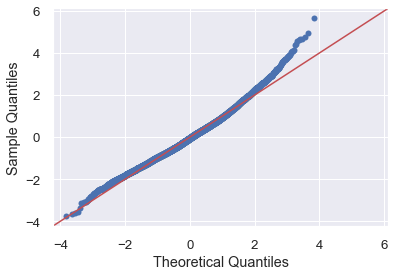

In [79]:
# Check that the residuals are normally distributed
fig = sm.graphics.qqplot(results_bm.resid, dist=stats.norm, line='45', fit=True)

#### Check the Homoscedasticity Assumption

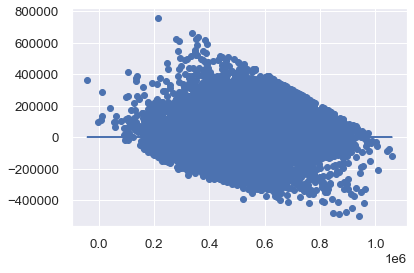

In [80]:
# Check that the residuals are homoscedastic
plt.scatter(results_bm.predict(X_train_bm), results_bm.resid)
plt.plot(results_bm.predict(X_train_bm), [0 for i in range(len(X_train_bm))])

#### Baseline Model Validation

In [81]:
bm_score = results_bm.rsquared_adj
bm_score

0.5336159114676063

In [82]:
# Calculate predictions on training and test sets
y_hat_train = results_bm.predict(X_train_bm)
y_hat_test = results_bm.predict(X_test_bm) 

In [83]:
# Calculate training and test residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [84]:
# Calculate training and test MSE
train_mse_bm = mean_squared_error(y_train, y_hat_train)
test_mse_bm = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error of Baseline Model:', train_mse_bm)
print('Test Mean Squarred Error of Baseline Model:', test_mse_bm)

Train Mean Squarred Error of Baseline Model: 17860889575.00817
Test Mean Squarred Error of Baseline Model: 17756931883.607746


In [85]:
# Calculate training and test RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

train_rmse_bm = rmse(y_hat_train, y_train)
test_rmse_bm = rmse(y_hat_test, y_test)
print('Train Root Mean Squarred Error of Baseline Model:', train_rmse_bm)
print('Test Root Mean Squarred Error of Baseline Model:', test_rmse_bm)

Train Root Mean Squarred Error of Baseline Model: 133644.63915551634
Test Root Mean Squarred Error of Baseline Model: 133255.13830095914


### Model 1 - remove uninfluential features by stepwise selection with p-values

#### Stepwise Selection with P-values

In [86]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(included[worst_feature]) #change is here. 
                        # Instead of remove worst_feature, we remove SalePrice WD
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [87]:
feat = stepwise_selection(X, y, verbose = True)
print('resulting features:')
print(feat)

Add  sqft_living15                  with p-value 0.0
Add  grade                          with p-value 0.0
Add  above_70                       with p-value 0.0
Add  sqft_living                    with p-value 9.12493e-250
Add  sqft_basement                  with p-value 4.52459e-61
Add  condition_5                    with p-value 2.46736e-45
Add  condition_4                    with p-value 7.3268e-24
Add  waterfront                     with p-value 2.25386e-21
Add  floors                         with p-value 4.81976e-14
Add  bedrooms                       with p-value 3.38622e-09
resulting features:
['sqft_living15', 'grade', 'above_70', 'sqft_living', 'sqft_basement', 'condition_5', 'condition_4', 'waterfront', 'floors', 'bedrooms']


#### Adjusting Baseline Model

In [88]:
drop_col = list(set(df[x_cols])-set(feat))
drop_col

['sqft_lot', 'condition_2', 'sqft_lot15', 'bathrooms', 'condition_1']

In [89]:
X_train_m1 = X_train.drop(drop_col, axis = 1)
X_test_m1 = X_test.drop(drop_col, axis = 1)

In [90]:
len(X_train_m1), len(y_train)

(14991, 14991)

In [91]:
X_train_m1 = sm.add_constant(X_train_m1)
X_test_m1 = sm.add_constant(X_test_m1)

In [92]:
# Fitting the actual model
model_m1 = sm.OLS(y_train, X_train_m1)
results_m1 = model_m1.fit()
print(results_m1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     1710.
Date:                Wed, 22 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:36:29   Log-Likelihood:            -1.9823e+05
No. Observations:               14991   AIC:                         3.965e+05
Df Residuals:                   14980   BIC:                         3.966e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.508e+05    1.1e+04    -40.814

#### Check the Normality Assumption 

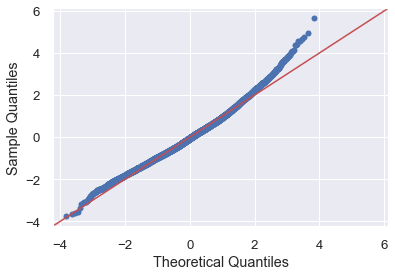

In [93]:
fig = sm.graphics.qqplot(results_m1.resid, dist=stats.norm, line='45', fit=True)

#### Check the Homoscedasticity Assumption

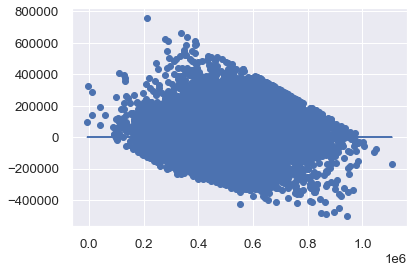

In [94]:
# Check that the residuals are homoscedastic
plt.scatter(results_m1.predict(X_train_m1), results_m1.resid)
plt.plot(results_m1.predict(X_train_m1), [0 for i in range(len(X_train_m1))])

#### Model 1 Validation

In [95]:
m1_score = results_m1.rsquared_adj
m1_score

0.5327379649626016

In [96]:
y_hat_train_m1 = results_m1.predict(X_train_m1)
y_hat_test_m1 = results_m1.predict(X_test_m1)

In [97]:
train_rmse_m1 = rmse(y_hat_train_m1, y_train)
test_rmse_m1 = rmse(y_hat_test_m1, y_test)
print('Train Root Mean Squarred Error of Refined Model #1:', train_rmse_m1)
print('Test Root Mean Squarred Error of Refined Model #1:', test_rmse_m1)

Train Root Mean Squarred Error of Refined Model #1: 133792.70036121627
Test Root Mean Squarred Error of Refined Model #1: 133262.1336043119


### Model 2 - Scale the predictors based on Baseline Model

#### Scaling the Predictors

Since the features are in different scale, we want to scale the features before we train the model.

In [98]:
# Create the Scaler object
scaler = MinMaxScaler()
X_train_features = scaler.fit_transform(X_train)
X_test_features = scaler.fit_transform(X_test)

In [99]:
X_train_m2 = pd.DataFrame(X_train_features, index=X_train.index, columns=X_train.columns)
X_test_m2 = pd.DataFrame(X_test_features, index=X_test.index, columns=X_test.columns)

In [100]:
X_train_m2 = sm.add_constant(X_train_m2)
X_test_m2 = sm.add_constant(X_test_m2)

In [101]:
len(X_train_m2), len(y_train)

(14991, 14991)

In [102]:
#Fitting the actual model
model_m2 = sm.OLS(y_train, X_train_m2)
results_m2 = model_m2.fit()
print(results_m2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     1144.
Date:                Wed, 22 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:36:30   Log-Likelihood:            -1.9821e+05
No. Observations:               14991   AIC:                         3.965e+05
Df Residuals:                   14975   BIC:                         3.966e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.429e+04   5388.759     -8.219

#### Check the Normality Assumption

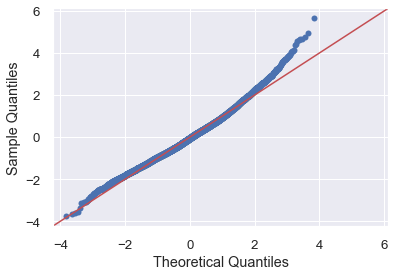

In [103]:
fig = sm.graphics.qqplot(results_m2.resid, dist=stats.norm, line='45', fit=True)

#### Check the Homoscedasticity Assumption

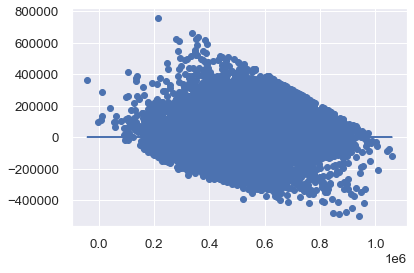

In [104]:
# Check that the residuals are homoscedastic
plt.scatter(results_m2.predict(X_train_m2), results_m2.resid)
plt.plot(results_m2.predict(X_train_m2), [0 for i in range(len(X_train_m2))])

#### Model 2 Validation

In [105]:
m2_score = results_m2.rsquared_adj
m2_score

0.5336159114676065

In [106]:
y_hat_train_m2 = results_m2.predict(X_train_m2)
y_hat_test_m2 = results_m2.predict(X_test_m2)

In [107]:
train_rmse_m2 = rmse(y_hat_train_m2, y_train)
test_rmse_m2 = rmse(y_hat_test_m2, y_test)
print('Train Root Mean Squarred Error of Refined Model #2:', train_rmse_m2)
print('Test Root Mean Squarred Error of Refined Model #2:', test_rmse_m2)

Train Root Mean Squarred Error of Refined Model #2: 133644.6391555163
Test Root Mean Squarred Error of Refined Model #2: 134228.73758665269


### Summary Table

In [108]:
pd.set_option('display.float_format', '{:.6f}'.format)
pd.DataFrame([[bm_score, m1_score, m2_score],
              [train_rmse_bm, train_rmse_m1, train_rmse_m2],
              [test_rmse_bm, test_rmse_m1, test_rmse_m2]], 
             columns = ['Baseline Model', 'Model 1', 'Model 2'],
             index = ['Adj R Squared', 'RMSE_train', 'RMSE_test'])

,Baseline Model,Model 1,Model 2
Adj R Squared,0.533616,0.532738,0.533616
RMSE_train,133644.639156,133792.700361,133644.639156
RMSE_test,133255.138301,133262.133604,134228.737587


Comments: 
- The three models have the same adjusted r-squared.
- Baseline Model is the best one with the smallest error.
- Removing 'sqft_lot' and 'renovation' feature does not help improve the model.
- Model 2 has a worse test RMSE compared with that of Baseline Model. However, the scaled predictors will help to determine what are the top features when determining the value of houses.

#### Cross Validation of the Baseline Model

In [109]:
linreg = LinearRegression()
linreg.fit(X_train_m1, y_train)
mse = make_scorer(mean_squared_error)
cv_5_train = cross_val_score(linreg, X_train_m1, y_train, cv=5, scoring=mse)
cv_5_test = cross_val_score(linreg, X_test_m1, y_test, cv=5, scoring=mse)
cv_5_train_mean = cv_5_train.mean()
cv_5_test_mean = cv_5_test.mean()
print('Train cross validation score of Model 1:', cv_5_train_mean)
print('Test cross validation score of Model 1:', cv_5_test_mean)

Train cross validation score of Model 1: 17932641307.717556
Test cross validation score of Model 1: 17843134728.015923


Comments:

- Upon the cross validation, the test MSE is larger than the train MSE, but they are close. That means our model works.

### Results

In [110]:
pd.set_option('display.float_format', '{:.2f}'.format)
params = pd.DataFrame(list(zip(X_train_bm.columns, np.transpose(results_bm.params),
                np.transpose(results_m2.params))),
                columns = ['features', 'Best Model', 'Scaled Model'])
params = params.set_index('features') 

In [111]:
params_df = params.reindex(params['Scaled Model'].abs().sort_values(ascending = False).index)
params_df

,Best Model,Scaled Model
features,,
grade,88008.03,616056.23
sqft_living,55.25,313822.97
sqft_lot,0.18,294925.91
sqft_living15,53.58,243820.86
sqft_lot15,-0.23,-201974.50
waterfront,187970.77,187970.77
above_70,135052.26,135052.26
sqft_basement,49.64,135028.60
condition_5,62936.80,62936.80


In [112]:
params_m1 = params_df.drop(index='const', columns='Scaled Model')
pd.options.display.float_format = '${:,.2f}'.format
params_m1

,Best Model
features,
grade,"$88,008.03"
sqft_living,$55.25
sqft_lot,$0.18
sqft_living15,$53.58
sqft_lot15,$-0.23
waterfront,"$187,970.77"
above_70,"$135,052.26"
sqft_basement,$49.64
condition_5,"$62,936.80"


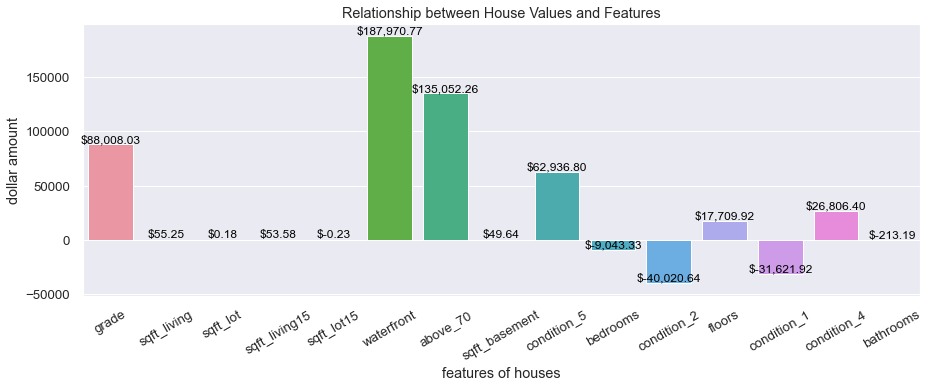

In [113]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x=params_m1.index, y=params_m1['Best Model'])
ax.set(title = 'Relationship between House Values and Features',
       xlabel='features of houses', ylabel='dollar amount')
plt.setp(ax.get_xticklabels(), rotation=30)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '${:,.2f}'.format(p.get_height()), 
        fontsize=12, color='black', ha='center', va='bottom')
plt.show()

## Conclusion

The top features to determine the value of houses are:
1. grade: overall grade given to the housing unit, based on King County grading system
2. sqft_living: footage of the house
3. sqft_lot: footage of the lot
4. sqft_living15: The square footage of interior housing living space for the nearest 15 neighbors
5. sqft_lot15: The square footage of the land lots of the nearest 15 neighbors
6. waterfront: whether the house has a view to a waterfront
7. the age of the house: whether the house is 70 years older or not

The relationship between the value of house and the key features:

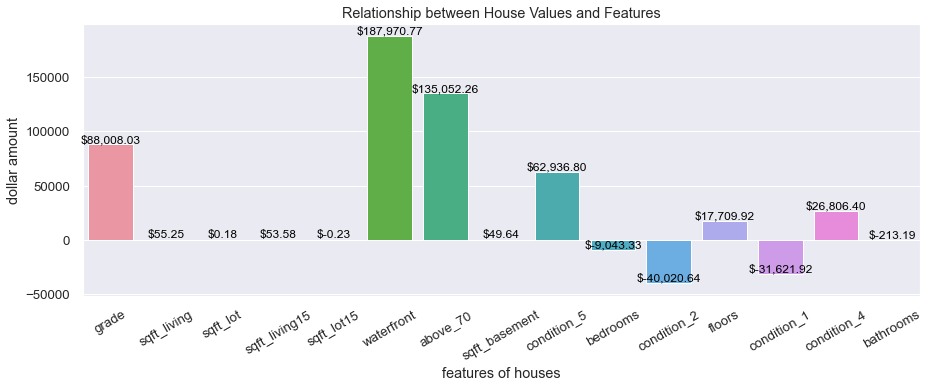

## Next Step

1. Need more house sale data, not only for the period of 2014-2015
2. Analyze the relationship between sqft_living and number of bedrooms/bathrooms
3. Analyze the age of houses
4. Analyze the zipcode/location feature